In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis')

from src.models.constants import STATIC_FEATURES, TIME_SERIES_FEATURES
from src.data.live_season_data import GetFPLData
from src.features.custom_transformers import TimeSeriesFeatures

pd.set_option('display.max_columns', None)

DATA_PATH = 'data/processed/'

### Historical data

In [2]:
fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_2016_to_2019.parquet')
print(fpl_data_all_seasons.shape)
fpl_data_all_seasons.head()

(67986, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [3]:
# Columns used to train GW2 model
AVAILABLE_COLUMNS = [
    'name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
    'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'gw', 'season', 'team_name',
    'promoted_side', 'top_6_last_season', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'team_name_opponent', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Aug',
    'late_kickoff', 'early_kickoff', 'ID', 'kickoff_month_Apr', 'kickoff_month_Dec', 'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct',
    'kickoff_month_Sep'
]

In [4]:
fpl_data_all_seasons = fpl_data_all_seasons[AVAILABLE_COLUMNS]
fpl_data_all_seasons.shape

(67986, 52)

In [5]:
fpl_data_all_seasons['season_order'] = fpl_data_all_seasons['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [6]:
fpl_data_all_seasons.sort_values(['name', 'season_order', 'gw'], inplace=True)
fpl_data_all_seasons.reset_index(drop=True, inplace=True)

__Shift forward static features e.g. next opponent etc.__

In [7]:
for feature in ['value', 'was_home', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec',
                'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 
                'kickoff_month_Sep', 'late_kickoff', 'early_kickoff']:
    fpl_data_all_seasons[f'next_match_{feature}'] = fpl_data_all_seasons.groupby('name')[f'{feature}'].shift(-1)

### Create time series features

Create new ID

In [8]:
fpl_data_all_seasons.drop('ID', axis=1, inplace=True)

In [9]:
id_df = fpl_data_all_seasons.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1090, 2)


,name,ID
0,aaron_cresswell,1
1,aaron_lennon,2
2,aaron_mooy,3
3,aaron_ramsdale,4
4,aaron_ramsey,5


In [10]:
fpl_data_all_seasons = fpl_data_all_seasons.merge(id_df, how='left', on=['name'])

In [11]:
TIME_SERIES_FEATURES_LITE = list(set(AVAILABLE_COLUMNS).intersection(TIME_SERIES_FEATURES))

In [12]:
ts_features = TimeSeriesFeatures(halflife=4, max_lag=4, max_diff=4, columns=TIME_SERIES_FEATURES_LITE)

In [13]:
fpl_data_all_seasons[TIME_SERIES_FEATURES_LITE].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67986 entries, 0 to 67985
Data columns (total 25 columns):
selected             67986 non-null int64
value                67986 non-null float64
red_cards            67986 non-null int64
yellow_cards         67986 non-null int64
goals_scored         67986 non-null int64
transfers_balance    67986 non-null int64
ict_index            67986 non-null float64
clean_sheets         67986 non-null int64
total_points         67986 non-null int64
penalties_saved      67986 non-null int64
team_h_score         67986 non-null int64
goals_conceded       67986 non-null int64
transfers_out        67986 non-null int64
bps                  67986 non-null int64
own_goals            67986 non-null int64
team_a_score         67986 non-null int64
minutes              67986 non-null int64
influence            67986 non-null float64
assists              67986 non-null int64
bonus                67986 non-null int64
saves                67986 non-null int64
tra

In [14]:
for col in TIME_SERIES_FEATURES_LITE:
    fpl_data_all_seasons[col] = pd.to_numeric(fpl_data_all_seasons[col])

In [15]:
%%time
fpl_data_all_seasons_with_ts = ts_features.fit_transform(fpl_data_all_seasons)
print(fpl_data_all_seasons.shape)

(67986, 69)
CPU times: user 1min 52s, sys: 33.5 s, total: 2min 26s
Wall time: 1min 46s


In [16]:
fpl_data_all_seasons_with_ts.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

### 1. Build model to predict minutes played

In [18]:
played_model_data = fpl_data_all_seasons_with_ts.copy()[fpl_data_all_seasons_with_ts['season_order'] != 3]

In [19]:
played_model_data.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,

In [20]:
played_model_data['played'] = np.where(
    played_model_data['minutes'] == 0,
    0,
    1
)
played_model_data.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,

In [21]:
played_model_data['played_plus_1_gw'] = played_model_data.groupby(['name'])['played'].shift(-1)

In [22]:
played_model_data = played_model_data[
    ~played_model_data['played_plus_1_gw'].isnull()
]

In [23]:
played_model_data.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,

In [24]:
played_model_data['next_match_was_home'] = played_model_data['next_match_was_home'].astype(bool)

In [29]:
import lightgbm

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [27]:
from scipy.stats import uniform, randint

In [54]:
gs_params = {
    'learning_rate': uniform(),
    'max_depth': randint(1, 50),
    'n_estimators': randint(1, 200),
    'num_leaves': randint(1, 60),
    'reg_alpha': uniform(),
    'reg_lambda': uniform()
}

In [55]:
random_search = RandomizedSearchCV(
    lightgbm.LGBMClassifier(),
    param_distributions=gs_params,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=2
)

In [56]:
random_search.fit(
    played_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'played_plus_1_gw', 'ID'],
        axis=1
    ),
    played_model_data['played_plus_1_gw']
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086, total=   4.8s
[CV] learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086, total=   4.7s
[CV] learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086 
[CV]  learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086, total=   4.2s
[CV] learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086 
[CV]  learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086, total=   4.7s
[CV] learning_rate=0.1812534103889113, max_depth=20, n_estimators=130, num_leaves=2, reg_alpha=0.34334645547742915, reg_lambda=0.018856740254133086 
[CV]  learning_rate=0.1812534103889113, max_depth=20, n_estim

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a370f2748>,


In [60]:
random_search.best_params_

{'learning_rate': 0.09686910095549073,
 'max_depth': 36,
 'n_estimators': 69,
 'num_leaves': 19,
 'reg_alpha': 0.9598406941608779,
 'reg_lambda': 0.15186365300524518}

In [61]:
random_search.best_score_

0.8553559194678335

In [59]:
random_search.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.09686910095549073,
               max_depth=36, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=69, n_jobs=-1, num_leaves=19,
               objective=None, random_state=None, reg_alpha=0.9598406941608779,
               reg_lambda=0.15186365300524518, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [62]:
import shap

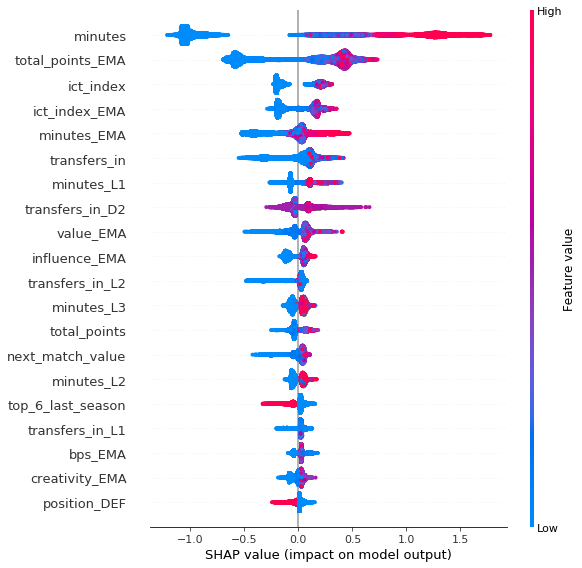

In [63]:
# LightGBM shap
shap_values = shap.TreeExplainer(random_search.best_estimator_).shap_values(
    played_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'played_plus_1_gw', 'ID'],
        axis=1
    )
)
shap.summary_plot(
    shap_values,
    played_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'played_plus_1_gw', 'ID'],
        axis=1
    )
)

In [71]:
# Save model
import pickle
model_fp = 'src/models/pickles/'
pickle.dump(random_search.best_estimator_, open(model_fp + 'lgbm_played_model.pickle', 'wb'))

### How does model compare with baseline?

Baseline prediction: If you don't play in current GW, predict that you won't play in the next GW

In [65]:
played_model_data['baseline_prediction'] = np.where(
    played_model_data['played']==0,
    0,
    1
)

In [67]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(played_model_data['played_plus_1_gw'], played_model_data['baseline_prediction'])

0.8465601449755795

__Only a marginal improvement vs baseline!__

Note: In real-time we also have injury status so can predict with more certainty some players that they won't play (not available for training)

# TODO: Try predicting <30/60 minutes i.e. who are squad players rotated in and out of team

### 2. Model to predict total points when minutes > 0

In [75]:
points_model_data = fpl_data_all_seasons_with_ts[fpl_data_all_seasons_with_ts['season_order'] != 3]

In [77]:
points_model_data['total_points_plus_1_gw'] = points_model_data.groupby(['name'])['total_points'].shift(-1)

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
points_model_data = points_model_data[~points_model_data['total_points_plus_1_gw'].isnull()]

In [79]:
points_model_data['played'] = np.where(
    points_model_data['minutes'] == 0,
    0,
    1
)

In [80]:
points_model_data['played_plus_1_gw'] = points_model_data.groupby(['name'])['played'].shift(-1)

In [81]:
# Only keep player-gameweeks where they scored points in the following gameweek
points_model_data = points_model_data[points_model_data['played_plus_1_gw'] == 1]

# TODO: Do randomised search

In [82]:
gs_params = {
    'learning_rate': 0.03,
     'max_depth': -1,
     'n_estimators': 200,
     'num_leaves': 50,
     'reg_alpha': 0.03
}
lgbm_model = lightgbm.LGBMRegressor(**gs_params)

In [83]:
points_model_data['next_match_was_home'] = points_model_data['next_match_was_home'].astype(bool)

In [84]:
%%time
lgbm_model.fit(
    points_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    ),
    points_model_data['total_points_plus_1_gw']
)

CPU times: user 47.5 s, sys: 964 ms, total: 48.4 s
Wall time: 13.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [85]:
predictions = lgbm_model.predict(
    points_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    )
)

In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [97]:
mean_squared_error(points_model_data['total_points_plus_1_gw'], predictions)**0.5

2.27031815835316

In [95]:
mean_absolute_error(points_model_data['total_points_plus_1_gw'], predictions)

1.6677374122831297

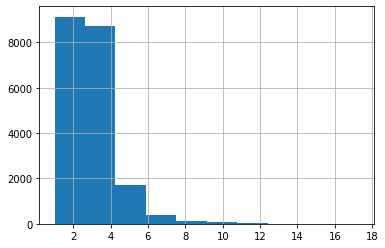

In [98]:
pd.Series(predictions).hist()

In [99]:
points_model_data['predictions'] = predictions

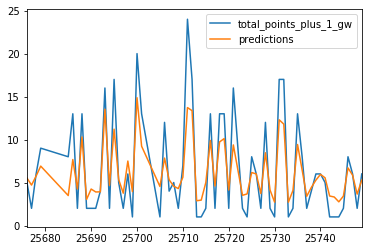

In [116]:
points_model_data[points_model_data['name'] == 'harry_kane'][['total_points_plus_1_gw', 'predictions']].plot()

# TODO Do shapley plot for regression model

# TODO Use both models and get sense of error and distribution of predictions